In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

DFT = '#67568c'
PRE_TRAIN = "orange"
FINE_TUNE = '#ff6e6c'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from digital_experiments import all_experiments


df = all_experiments("../experiment-logs/cv/pre-train-on-synthetic")

best_pretraining = df.sort_values(("results.fine_tune.structure.rmse.test.mean")).iloc[0]
best_pretraining

id                                             221123-001704-1762-bare-wait
config.pre_lr                                                      0.000931
config.pre_weight_decay                                            0.000001
config.pre_dropout                                                      0.5
config.lr                                                           0.00054
config.weight_decay                                                 0.01391
config.dropout                                                          0.0
config.hidden_size                                                      827
results.fine_tune.local.mae.train.mean                             0.274453
results.fine_tune.local.mae.train.std                              0.018557
results.fine_tune.local.mae.val.mean                               0.274727
results.fine_tune.local.mae.val.std                                0.017988
results.fine_tune.local.mae.test.mean                              0.274731
results.fine

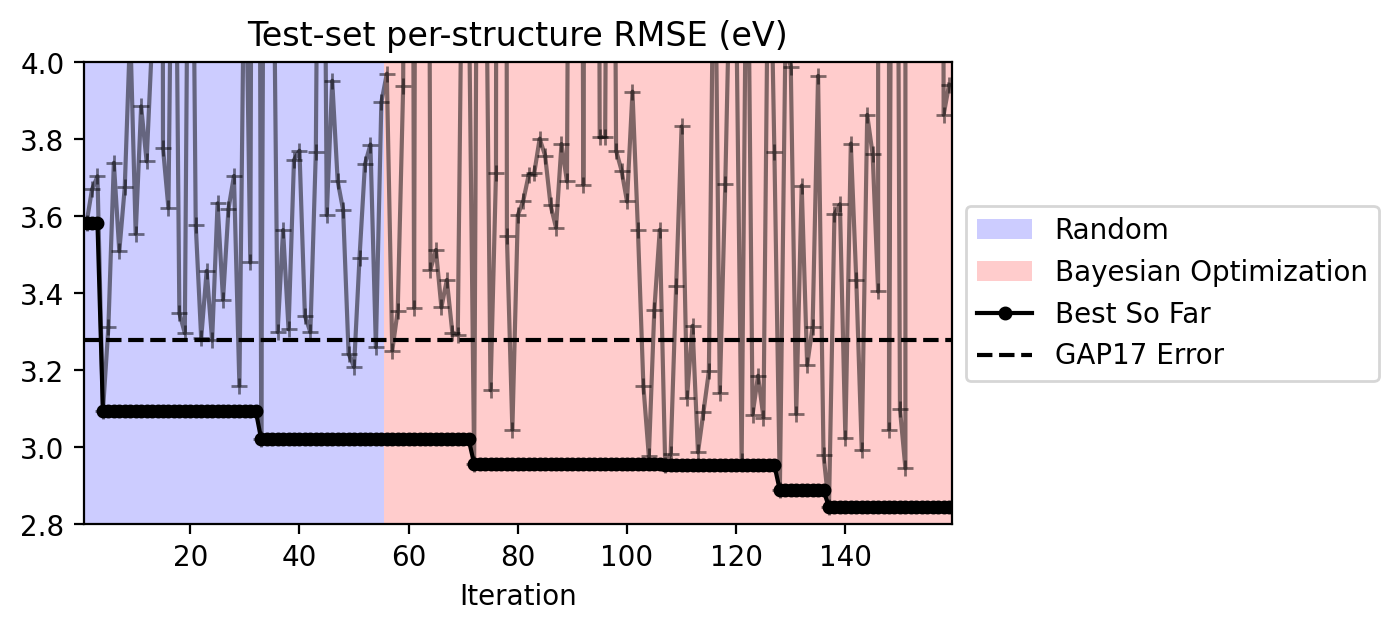

In [4]:
from digital_experiments.plots import track_minimization, legend_outside
%config InlineBackend.figure_format = "retina"

plt.figure(figsize=(7, 3))
track_minimization("../experiment-logs/cv/pre-train-on-synthetic", lambda x: x['fine_tune']['structure']['rmse']['test']['mean'])
plt.ylim(2.8, 4)
plt.title("Test-set per-structure RMSE (eV)")
plt.axhline(3.28, color="black", linestyle="--", label="GAP17 Error")
legend_outside(plt.gca())

# Learning Curves

In [5]:
def fancy_fill(x, y_mean, y_std, *args, s=4, label=None, markeredgecolor=None,**kwargs):
    plt.plot(x, y_mean, *args, label=label, markersize=s, markeredgecolor=markeredgecolor, **kwargs)
    plt.fill_between(x, y_mean - y_std, y_mean + y_std, alpha=0.05, **kwargs)
    plt.plot(x, y_mean - y_std, alpha=0.1, linewidth=1, **kwargs)
    plt.plot(x, y_mean + y_std, alpha=0.1, linewidth=1, **kwargs)

# New Pretrain Dataset

In [6]:
from digital_experiments import experiments_matching

df = experiments_matching("../experiment-logs/pre-train-on-synthetic", config={"hidden_size": 827, "n_finetune": -1})
df = df[df["config.n_pretrain"] != -1]
df["config.n_pretrain"] = df["config.n_pretrain"] * 200
df["config.all_data"].fillna(False, inplace=True)

df = df[df["config.all_data"] == True]

cross_val_df = df.groupby(["config.n_pretrain"])[["results.fine_tune.structure.rmse.test", "results.fine_tune.structure.rmse.train"]].agg(["mean", "std"]).reset_index()
cross_val_df.rename(columns={"config.n_pretrain": "n_atoms", "results.fine_tune.structure.rmse.test": "test", "results.fine_tune.structure.rmse.train": "train"}, inplace=True)

pre_train_mean = cross_val_df["train"]["mean"] * 1000 / 64
pre_train_std = cross_val_df["train"]["std"] * 1000 / 64

pre_test_mean = cross_val_df["test"]["mean"] * 1000 / 64
pre_test_std = cross_val_df["test"]["std"] * 1000 / 64

pre_n_atoms = cross_val_df["n_atoms"]

df = experiments_matching("../experiment-logs/pre-train-on-synthetic", config={"hidden_size": 827, "n_pretrain": -1})
df = df[df['config.n_finetune'] != -1]
df["config.n_finetune"] *= 64
df["config.all_data"].fillna(False, inplace=True)
df = df[df['config.all_data'] == True]

cross_val_df = df.groupby(["config.n_finetune"])[["results.fine_tune.structure.rmse.test", "results.fine_tune.structure.rmse.train"]].agg(["mean", "std"]).reset_index()
cross_val_df.rename(columns={"config.n_finetune": "n_atoms", "results.fine_tune.structure.rmse.test": "test", "results.fine_tune.structure.rmse.train": "train"}, inplace=True)

fine_train_mean = cross_val_df["train"]["mean"] * 1000 / 64
fine_train_std = cross_val_df["train"]["std"] * 1000 / 64

fine_test_mean = cross_val_df["test"]["mean"] * 1000 / 64
fine_test_std = cross_val_df["test"]["std"] * 1000 / 64

fine_n_atoms = cross_val_df["n_atoms"]

df = experiments_matching("../experiment-logs/train-on-dft", config={"hidden_size": 334})
df = df[df["config.n_train"] > 0]

cross_val_df = df.groupby(["config.n_train"])[["results.structure.rmse.test", "results.structure.rmse.train"]].agg(["mean", "std"]).reset_index()
cross_val_df.rename(columns={"config.n_train": "n_atoms", "results.structure.rmse.test": "test", "results.structure.rmse.train": "train"}, inplace=True)

dft_train_mean = cross_val_df["train"]["mean"] * 1000 / 64
dft_train_std = cross_val_df["train"]["std"] * 1000 / 64

dft_test_mean = cross_val_df["test"]["mean"] * 1000 / 64
dft_test_std = cross_val_df["test"]["std"] * 1000 / 64

dft_n_atoms = cross_val_df["n_atoms"] * 64

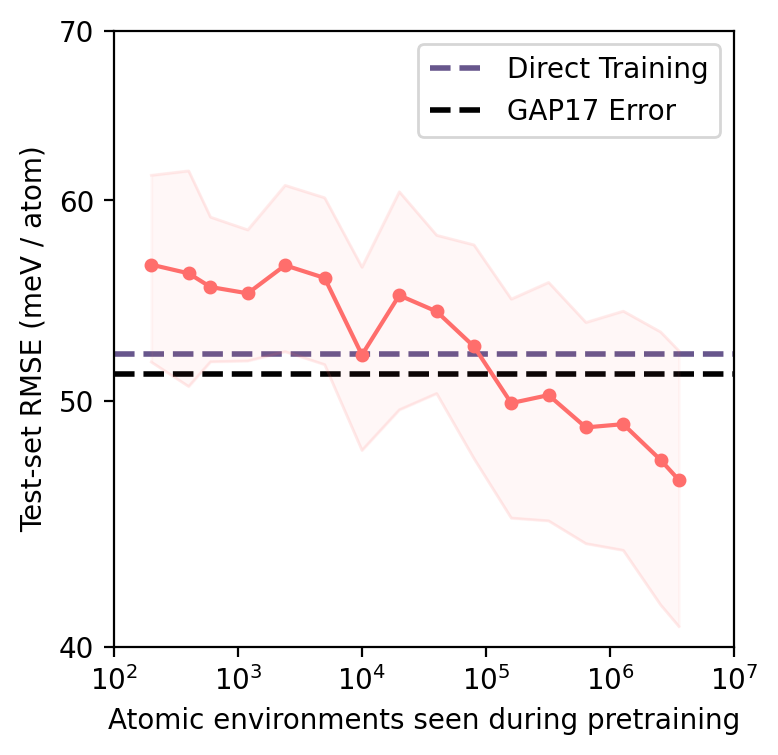

In [8]:
plt.figure(figsize=(4, 4))

fancy_fill(pre_n_atoms, pre_test_mean, pre_test_std, "-o", color=FINE_TUNE)

plt.xscale("log")
plt.xlabel("Atomic environments seen during pretraining")
plt.ylabel("Test-set RMSE (meV / atom)")

powers = np.array([2, 3, 4, 5, 6, 7])
plt.xticks(10 ** powers, [f"$10^{{{p}}}$" for p in powers])


plt.yscale("log")
ticks = [40, 50, 60, 70]
plt.yticks(ticks, ticks)
plt.ylim(bottom=40)

plt.axhline(52.2, color=DFT, linestyle="--", label="Direct Training", zorder=-1, linewidth=2)
plt.axhline(3.28 / 64 * 1000, color="black", linestyle="--", label="GAP17 Error", zorder=-1, linewidth=2)
# plt.axhline(52, color=DFT, linestyle="--", label="Direct Training", linewidth=3)
plt.legend()
# plt.title("Pre-training dataset size")
plt.minorticks_off()
plt.savefig("pre-training-dataset-size.png", bbox_inches="tight", dpi=200)

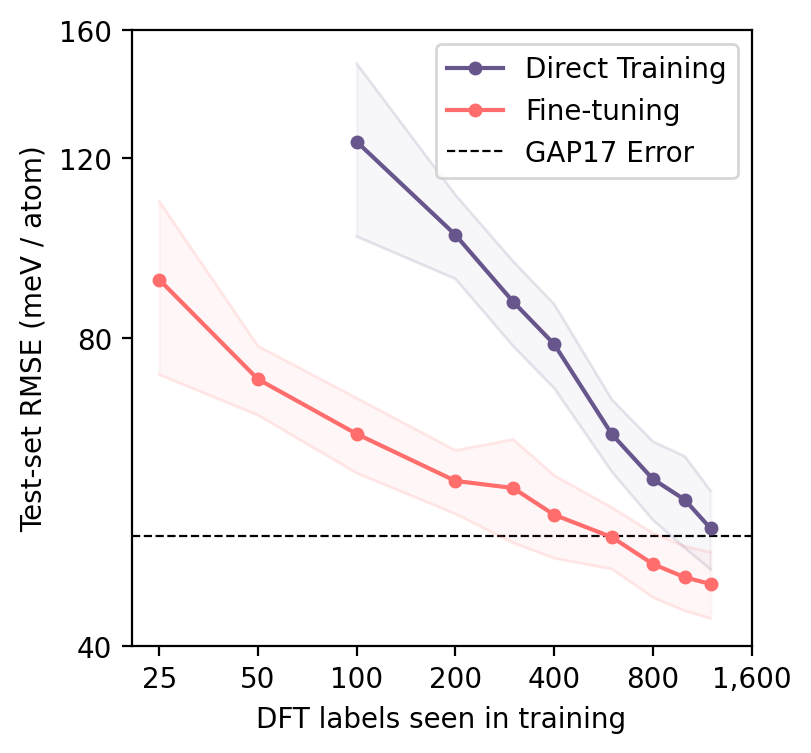

In [9]:
min_atoms = 10
dft_min_atoms = 100

idxs = dft_n_atoms >= dft_min_atoms * 64

plt.figure(figsize=(4, 4))
fancy_fill(dft_n_atoms[idxs], dft_test_mean[idxs], dft_test_std[idxs], "-o", color=DFT, label="Direct Training")

idxs = fine_n_atoms >= min_atoms * 64
fancy_fill(fine_n_atoms[idxs], fine_test_mean[idxs], fine_test_std[idxs], "-o", color=FINE_TUNE, label="Fine-tuning")


ticks = np.array([25, 50, 100, 200, 400, 800, 1600])
ticks = ticks[ticks >= min_atoms]
plt.xscale("log")
plt.xticks(ticks * 64, [f"{t:,}" for t in ticks])
plt.xlabel("DFT labels seen in training")

plt.ylabel("Test-set RMSE (meV / atom)")
plt.yscale("log")
ticks = 40 * np.array([1, 2, 3, 4])
plt.yticks(ticks, ticks)
plt.ylim(bottom=40)

plt.axhline(3.28 / 64 * 1000, color="black", linestyle="--", label="GAP17 Error", zorder=-1, linewidth=0.8)

plt.legend()
plt.minorticks_off()
plt.savefig("5-d.png", bbox_inches="tight", dpi=200)